# 1. Title and Executive Summary
## Fruit and Vegetable Prices Analysis
**Author:** Loc Nguyen  
**Date:** December 7th 2025

## Executive Summary
This project analyzes fruit and vegetable prices from the USDA Economic Research Service database.  
The goal is to explore retail price distributions, understand relationships between forms and prices, and provide insights into which fruits provide the best value for consumers.  

Key questions include:
- How do prices vary among different fruits?
- Are fresh fruits more expensive than non-fresh forms?
- What is the correlation between retail price and cup equivalent price?


# 2. Data Card
## Dataset Overview
- **Source:** USDA Economic Research Service – Fruit and Vegetable Prices  
  [Link](https://www.ers.usda.gov/data-products/fruit-and-vegetable-prices/)
- **License:** Creative Commons CCZero ([Link](http://www.opendefinition.org/licenses/cc-zero))
- **Fields:**
  - `Fruit`: Name of the fruit
  - `Form`: Form of the fruit (Fresh, Canned, Frozen, Juice, etc.)
  - `RetailPrice`: Price per unit
  - `RetailPriceUnit`: Unit of pricing
  - `Yield`: Edible yield percentage
  - `CupEquivalentSize`: Amount needed for 1 edible cup
  - `CupEquivalentUnit`: Unit for cup conversion
  - `CupEquivalentPrice`: Cost per edible cup
- **Limitations:** Some fruits may have missing forms; dataset may not reflect regional price differences.
- **Rationale for selection:** Provides real-world economic and nutritional data that can be analyzed for price patterns, value assessment, and health insights.


# 3. Loading and File IO
## Setup and Import Libraries

In [26]:
# 🚀 Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

try:
  import plotly.express as px
  import plotly.graph_objects as go
  PLOTLY_AVAILABLE = True
except ImportError:
  PLOTLY_AVAILABLE = False
  print("Note: Plotly not available. Interactive visualizations will be skipped.")

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## Visualization Style Setup

In [3]:
# =============================================================================
# VISUALIZATION STYLE SETUP
# =============================================================================
# Inspired from Professor Gilany's Visualization Style Setup
# Setting up consistent styling for al
# l our charts
# Set default matplotlib parameters
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'normal',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'patch.linewidth': 0.5,
    'patch.edgecolor': 'white',
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3
})
# Set the overall style
sns.set_style('whitegrid', {
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'axes.edgecolor': '.2',
    'axes.linewidth': 1.2
})
sns.set_context('notebook', font_scale=1.1)

# Define a clean, modern color palette
sns.set_palette("pastel")

print("✅ Theme successfully loaded! All visualizations will use consistent styling.")

✅ Theme successfully loaded! All visualizations will use consistent styling.


## 📊 Loading the Data
Load the fruit and vegetable prices dataset

In [4]:
def load_csv(path: Path) -> pd.DataFrame:
  try:
    df = pd.read_csv(path)
  except FileNotFoundError as e:
    raise FileNotFoundError(
        f"Could not find {path.name}. check data/ folder and filename.") from e
  except pd.errors.ParserError as e:
    raise ValueError(
        f"Parsing failed for {path.name}. check delimiter or bad rows.") from e
  else:
    return df


# Load the fruit and vegetables dataset
path = 'data/Fruit-Prices-2022.csv'
df = load_csv(path)

# Display basic information about the dataset
print('Dataset Shape:', df.shape)
display(df.head())

Dataset Shape: (62, 8)


,Fruit,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice
0,Apples,Fresh,1.8541,per pound,0.90,0.2425,pounds,0.4996
1,"Apples, applesauce",Canned,1.1705,per pound,1.00,0.5401,pounds,0.6323
2,"Apples, ready-to-drink",Juice,0.8699,per pint,1.00,8.0000,fluid ounces,0.4349
3,"Apples, frozen concentrate",Juice,0.6086,per pint,1.00,8.0000,fluid ounces,0.3043
4,Apricots,Fresh,3.6162,per pound,0.93,0.3638,pounds,1.4145


### Creating new column
I decide to create `CoreFruit` column that shows the core fruit of each record in `Fruit` column 

In [5]:
# Create Core Fruit column
df['CoreFruit'] = df['Fruit'].str.split(',').str[0].str.strip()

To have data ready for visualization idea, I would also create `PriceCategory` column to show whether the fruit price is higher or lower than mean

In [20]:
# Create PriceCategory column
# Retrieve retail price
retail_price = df['RetailPrice']
retail_price_mean = retail_price.mean()
df['PriceCategory'] = np.where(retail_price < retail_price_mean, 'Low', 'High')
display(df.head())

,Fruit,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice,CoreFruit,PriceCategory
0,Apples,Fresh,1.8541,per pound,0.90,0.2425,pounds,0.4996,Apples,Low
1,"Apples, applesauce",Canned,1.1705,per pound,1.00,0.5401,pounds,0.6323,Apples,Low
2,"Apples, ready-to-drink",Juice,0.8699,per pint,1.00,8.0000,fluid ounces,0.4349,Apples,Low
3,"Apples, frozen concentrate",Juice,0.6086,per pint,1.00,8.0000,fluid ounces,0.3043,Apples,Low
4,Apricots,Fresh,3.6162,per pound,0.93,0.3638,pounds,1.4145,Apricots,High


# 4. Exploratory Data Analysis (EDA)

## 📊 Visualization Idea 1: Histogram and Box Plot - Distribution of Fruit Retail Price
The `RetailPrice` is a key variable because it shows the cost of different kinds of fruits even their forms. It helps contribute to visualize the `RetailPrice` distribution which is curicial insight for market analysis. By illustrating the distribution, we will know how the `RetailPrice` are spread out and even recognize the outlier, and the price consistency. 

Let's first get a summary of the statistics and retrieve necessary value for visualization

In [ ]:
# Get the statistical summary
stats_summary = retail_price.describe()

# Compute statistics and convert to dictionary
# Outlier
iqr = stats_summary["75%"] - stats_summary["25%"]
lower_bound = stats_summary["25%"] - 1.5*iqr
upper_bound = stats_summary["75%"] + 1.5*iqr
outliers = retail_price[(retail_price < lower_bound) |
                        (retail_price > upper_bound)]

stats_dict = {
    'Mean': stats_summary['mean'],
    'Min': stats_summary['min'],
    'Q1 (25th percentile)': stats_summary["25%"],
    'Median (50th percentile)': stats_summary["50%"],
    'Q3 (75th percentile)': stats_summary["75%"],
    'Max': stats_summary['max'],
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,
    'Outlier Count': len(outliers),
    'Outliers List': outliers.to_string(index=False)
}

# Tidy table
stats_df = stats_summary.to_frame().T
stats_df['Outliers'] = stats_dict['Outlier Count']
stats_df.columns = ['Count', 'Mean', 'Std', 'Min',
                    'Q1 25%', 'Median 50%', 'Q3 75%', 'Max', 'Outliers']
tidy_table = stats_df.style.format('{:.2f}')
display(tidy_table)

print(f"Outlier value:\n{stats_dict['Outliers List']}")
print(
    f"Bounds: {stats_dict['Lower Bound']:.2f} to {stats_dict['Upper Bound']:.2f}")

,Count,Mean,Std,Min,Q1 25%,Median 50%,Q3 75%,Max,Outliers
RetailPrice,62.00,2.99,2.27,0.38,1.36,2.16,4.12,10.30,1.00


Outlier value:
10.3035
Bounds: -2.76 to 8.24


### 📊 Fruit Price Dataset Summary
From the table summary, we can see:
- **Count:** 62 fruits  
- **Mean (Average):** ~2.99  
- **Standard Deviation (Std):** Measure of how spread out the prices are  
- **Minimum Price:** 0.38  
- **Maximum Price:** 10.30 also an outlier
- **Q1 (25% = 1.36):** One-quarter of fruits cost less than $1.36.  
- **Median (50% = 2.16):** Half of the fruits are priced below $2.16, and half above.  
- **Q3 (75% = 4.12):** Three-quarters of fruits are priced below $4.12, with the remaining quarter being more expensive. 
- **Outliers**: One outlier.
- **Bounds**: Range from -2.76 to 8.24, meaning there is no possible outlier on the low end, but it successfully identified the high price of 10.30 as an outlier.



In this section, I chose to visualize my findings using a histogram and a box plot. The histogram is a user-friendly chart for seeing the distribution with frequency and mean retail price. The box plot is more detailed, showing how the retail price spreads out among the population. It provides the quartiles, which divide the dataset into four parts, illustrating the price range of each part.

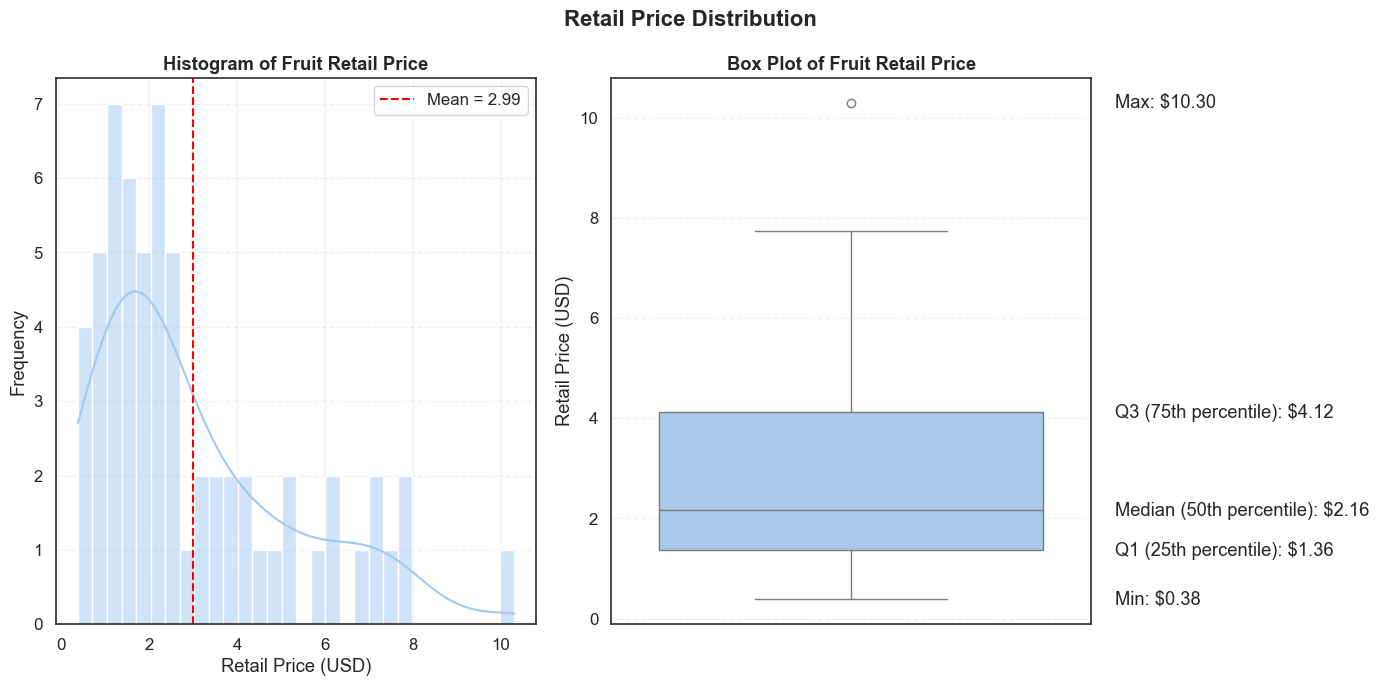

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Left panel: distribution
sns.histplot(data=df, x='RetailPrice', bins=30, kde=True,
             ax=axes[0])
axes[0].axvline(stats_dict['Mean'], color='red', linestyle='--',
                label=f'Mean = {stats_dict['Mean']:.2f}')
axes[0].set_xlabel('Retail Price (USD)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Fruit Retail Price')
axes[0].legend()

# Right panel: box plot
sns.boxplot(y=df['RetailPrice'], ax=axes[1])
axes[1].set_ylabel('Retail Price (USD)')
axes[1].set_title('Box Plot of Fruit Retail Price')

# Label value for box plot
label_order = ['Min', 'Q1 (25th percentile)',
               'Median (50th percentile)', 'Q3 (75th percentile)', 'Max']
for label, val in stats_dict.items():
  if label in label_order:
    axes[1].text(
        0.55,
        val,
        f'{label}: ${val:.2f}',
        va='center', ha='left',
    )


fig.suptitle('Retail Price Distribution', fontweight='bold')
plt.tight_layout()
plt.show()

I use a histogram with a KDE curve and a box plot to visualize the distribution of retail prices.  
This helps identify which price ranges are most common and detect any outliers.

### 🔍 Interpretation:

With two visualizations, they indicates that most products are cheap and clustered at the low price. There are a few expensive products, with the distributon extends toward higher price, which is confirmed by the mean is significantly greater than the median due to the extreme high outlier.

## 📊 Visualization Idea 2: Average Retail Price of Fresh Fruits
The previous visualization allowed us to see the overall retail price distribution among all product forms. To see each distinct fresh fruit's price, we will use an **interactive bar chart with Plotly**. This chart will show the average retail price for each specific fresh fruit and clearly display their names, that way we can easily compare individual fresh fruit cost.  

At first, we need to retrieve retail price for fresh fruits only

In [215]:
# Retrieve retail price for fresh fruits
fresh_retail_price = df.loc[df['Form'] ==
                            'Fresh', ['Fruit', 'Form', 'RetailPrice', 'RetailPriceUnit']]

display(fresh_retail_price)

,Fruit,Form,RetailPrice,RetailPriceUnit
0,Apples,Fresh,1.8541,per pound
4,Apricots,Fresh,3.6162,per pound
8,Bananas,Fresh,0.5971,per pound
10,Blackberries,Fresh,6.7483,per pound
12,Blueberries,Fresh,4.1575,per pound
14,Cantaloupe,Fresh,0.7523,per pound
15,Cherries,Fresh,4.6632,per pound
17,Clementines,Fresh,1.5811,per pound
23,Grapefruit,Fresh,1.4444,per pound
25,Grapes,Fresh,2.0363,per pound


Now, our data is ready for visualization.

In [216]:
# Plotly for bar chart
fig = px.histogram(
    fresh_retail_price, x='Fruit', y='RetailPrice',
    histfunc='avg',
    title='Interactive Bar Chart: Average Retail Price of Different Fruits Forms',
    labels={'RetailPrice': 'Retail Price'},
)
fig.show()

A bar chart (interactive using Plotly) is ideal for displaying multiple fruits with readable labels.  
This allows stakeholders to explore prices of fresh fruits in detail.


### 🔍 Interpretation:
This visualization clearly reveals the price hierarchy within the fresh fruit category. The five most expensive fresh fruits are: **raspberries, blackberries, cherries, blueberries, and apricots**. Conversely, the five least expensive fresh fruits are: **watermelon, bananas, pineapple, cantaloupe, and honeydew**. This Plotly visualization is utilized because its interactive feature allows us to hover over individual bars to view the precise average price, which static chart can not offer.

# 📊 Visualization Idea 3: Distribution Comparison Charts - Retail Price of Different Forms of Fruits Fresh vs Non-Fresh
In this section, we would explore the distribution of retail price of forms of fruit (Fresh vs Non-Fresh). We'll also check assumptions to conduct appropriate test. Together, statistical insights and visualization may determine whether observed differences in prices are genuine or could be due to random sampling variability.

At first, we want to check if Independent Samples t-Test is appropriate
### Assumption Check:
- Data values must be independent.  
- Data is normally distributed.  
- Data should have equal variances.  

Code to check assumptions from an example on [Medium](https://medium.com/@ryan_forrester_/t-tests-in-python-complete-guide-a4c2f21ffc72)


In [27]:
# Check if you have enough data
def check_sample_size(group1, group2):
  if len(group1) < 30 or len(group2) < 30:
    print("Warning: Small sample size may affect reliability")
    print(f"Group 1 size: {len(group1)}")
    print(f"Group 2 size: {len(group2)}")

# Test for normal distribution


def check_normality(data):
  _, p = stats.normaltest(data)
  print(f"Normality test p-value: {p:.4f}")
  if p < 0.05:
    print("Data may not be normally distributed")
    print("Consider using non-parametric tests")


group1 = df[df['Form'] == 'Fresh']['RetailPrice']
group2 = df[df['Form'] != 'Fresh']['RetailPrice']

# Check sample sizes
print("\nSample Size Check:")
check_sample_size(group1, group2)

# Check normality
print(f"\nNormality Check:")
check_normality(group1)
print(f"\nNormality Check:")
check_normality(group2)


Sample Size Check:
Group 1 size: 24
Group 2 size: 38

Normality Check:
Normality test p-value: 0.0009
Data may not be normally distributed
Consider using non-parametric tests

Normality Check:
Normality test p-value: 0.0476
Data may not be normally distributed
Consider using non-parametric tests


The data doesn't pass the assumption check to use t-test method, we'll need to use non-parametric alternative. For this I choose [Mann-Whitney U test](https://www.geeksforgeeks.org/machine-learning/mann-whitney-u-test-2/) because the sample size is small and the data doesn't follow a [normal distribution](https://www.geeksforgeeks.org/maths/normal-distribution/)

Mann-Whitney U Test will determine whether the distributions of the two groups are the same.


### 🧪Hypotheses:
- H0: (null hypothesis) The price distributions for `Fresh` and `Non-Fresh fruit` are the same.
- H1: (alternative hypothesis) The price distributions for `Fresh` and `Non-Fresh fruit` are different.


Now, we are ready to calculate statistic followed by this guidelines [Mann and Whitney U test](https://www.geeksforgeeks.org/machine-learning/mann-whitney-u-test-2/)

Python has a built-in function to easily calculate the value with **SciPy**

### Compute the Mann-Whitney U Statistic

In [ ]:
# Calculate t-statistics and p-value
fresh_prices = df[df['Form'] == 'Fresh']['RetailPrice']
others_prices = df[df['Form'] != 'Fresh']['RetailPrice']

res = stats.mannwhitneyu(
    fresh_prices, others_prices, alternative='two-sided')
print('Statistics=%.2f, p=%.2f' % (res[0], res[1]))
if res[1] < 0.05:
  print('Reject Null Hypothesis (Significant difference between two samples)')
else:
  print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Statistics=371.00, p=0.22
Do not Reject Null Hypothesis (No significant difference between two samples)


Based on the Mann-Whitney U test, there is no significant difference between the median retail price of the `Fresh` fruits and the `Non-Fresh` fruits at the 5% significance level.


Now, I would plot the **histogram** with the same data to see how it visually prove this evidence.

NameError: name 'fresh_prices' is not defined

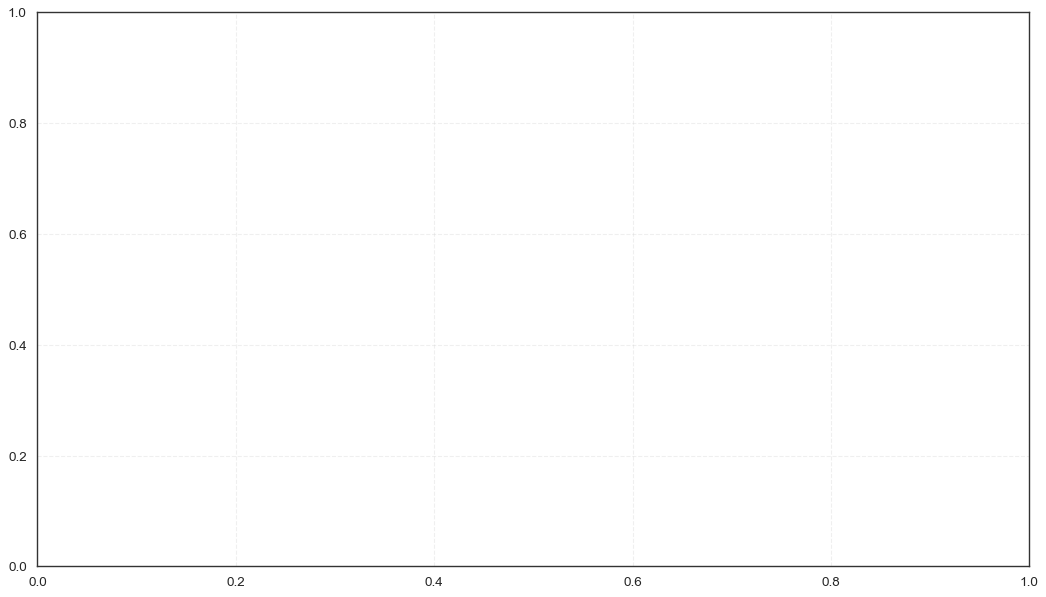

In [17]:
# Plot distributon comparison chart
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)
sns.histplot(x=fresh_prices, kde=True, color='#1f77b4',
             edgecolor='white', linewidth=2, alpha=0.6, label='Fresh')
sns.histplot(x=others_prices, kde=True, color='#ff7f0e',
             edgecolor='white', linewidth=2, alpha=0.6, label='Non-Fresh')
ax.set_title('Retail Price Distribution by Fresh vs Non-Fresh Fruits')
ax.set_xlabel('Retail Price')
ax.set_ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

A boxplot is used to compare Fresh and Non-Fresh fruit prices.  
It clearly shows median prices, interquartile ranges, and outliers for each category.

### 🔍 Interpretation:
The visualization shows that the retail price pattern for both groups is statistically similar in terms of central tendency and skewness, but the `Non-Fresh` fruit has a visibly higher count (volume) and a wider spread into the high-price range.  

This visual observation matches the conclusion from the statistical analysis, as the Mann-Whitney U test yielded a P-value of 0.22. Since p > 0.05, we do not reject the Null Hypothesis, confirming that there is no statistically significant difference between the overall retail price distributions of Fresh and Non-Fresh fruit in the population.

# 📊 Visualization Idea 4: Grouped Bar Chart - Retail Price of Different Fruits in Their Forms


In this section, we'll examine the retail price of 4 different fruits (`Blackberries`, `Blueberries`, `Raspberries`, and `Strawberries`) across their `Fresh` and `Frozen` forms. That way, we will identify whether each fruit and form tends to be cheaper or more expensive than other. 

At first, we need to filter out the four chosen fruits from the `CoreFruit` column.

In [235]:
# Filter specific fruits from dataset
filter_mask = (df['CoreFruit'].str.contains('Blackberries', case=False)
               | df['CoreFruit'].str.contains('Blueberries', case=False)
               | df['CoreFruit'].str.contains('Raspberries', case=False)
               | df['CoreFruit'].str.contains('Strawberries', case=False))
selected_fruits_df = df[filter_mask]
display(selected_fruits_df)

,Fruit,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice,CoreFruit
10,Blackberries,Fresh,6.7483,per pound,0.96,0.3197,pounds,2.2471,Blackberries
11,Blackberries,Frozen,4.8277,per pound,1.00,0.3307,pounds,1.5965,Blackberries
12,Blueberries,Fresh,4.1575,per pound,0.95,0.3197,pounds,1.3990,Blueberries
13,Blueberries,Frozen,3.8210,per pound,1.00,0.3307,pounds,1.2636,Blueberries
57,Raspberries,Fresh,7.7338,per pound,0.96,0.3197,pounds,2.5753,Raspberries
58,Raspberries,Frozen,6.1590,per pound,1.00,0.3307,pounds,2.0368,Raspberries
59,Strawberries,Fresh,2.9682,per pound,0.94,0.3197,pounds,1.0094,Strawberries
60,Strawberries,Frozen,3.3421,per pound,1.00,0.3307,pounds,1.1052,Strawberries


From the data we retrieved, these four fruits are only available in `Fresh` and `Frozen` forms, and we can group fruits in `Fresh` form into one group and those in `Frozen` form in another. A **grouped bar chart** will help us compare individual fruit prices within two groups, and also show the general price tendency between two groups.

Here we want to pivot tables to retrieve dataframe that different fruits in different forms will show its retail price, and it can be used to plot our chart

In [234]:
# Pivot so each fruit x form shows its retail price
price_table = selected_fruits_df.pivot_table(
    index='Form',
    columns='CoreFruit',
    values='RetailPrice',
    aggfunc='mean'
)
display(price_table)

CoreFruit,Blackberries,Blueberries,Raspberries,Strawberries
Form,,,,
Fresh,6.7483,4.1575,7.7338,2.9682
Frozen,4.8277,3.8210,6.1590,3.3421


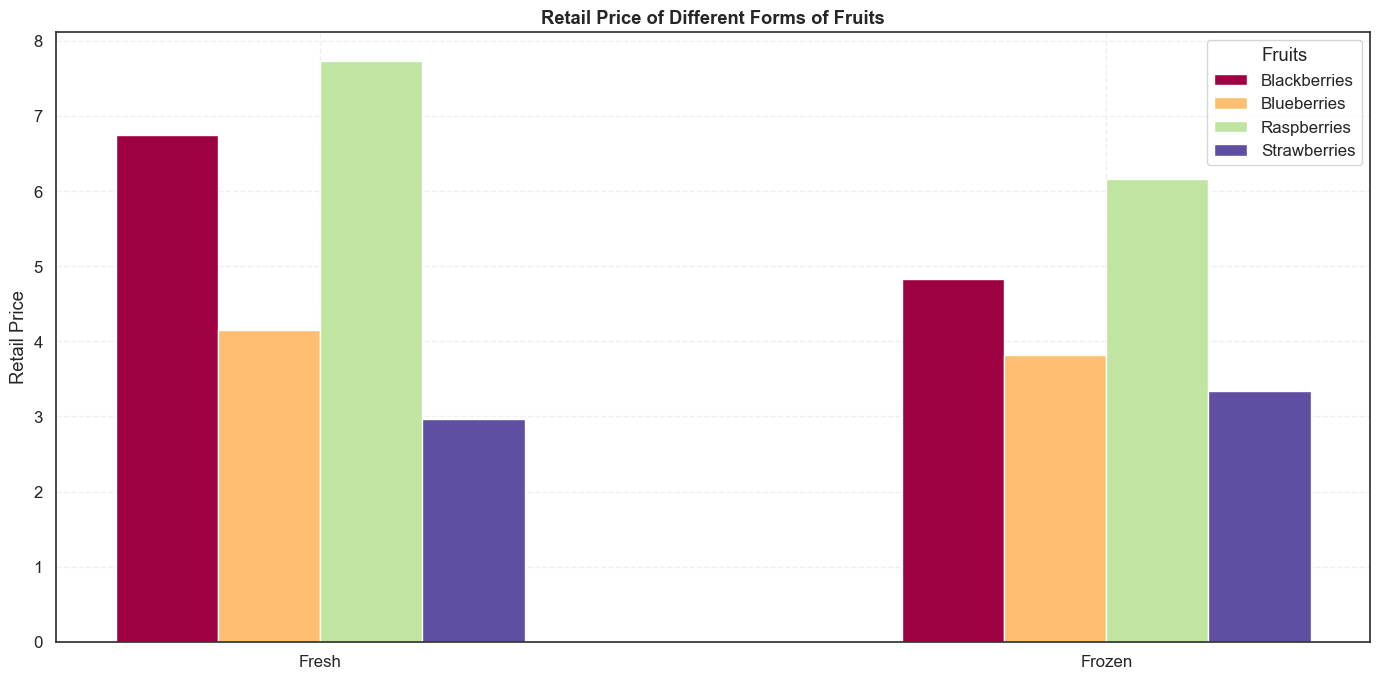

In [ ]:
# Set each fruit position
x = np.arange(len(price_table.index))


bar_width = 0.13

# Create fig and ax
fig, ax = plt.subplots(figsize=(14, 7))

cmap = plt.get_cmap('Spectral', len(price_table.columns))
for i, form in enumerate(price_table.columns):
  ax.bar(x+bar_width*i, price_table[form],
         width=bar_width, color=cmap(i), label=form)

ax.set_xticks(x + bar_width * (len(price_table.columns) - 1) / 2)
ax.set_xticklabels(price_table.index)

ax.set_title('Retail Price of Different Forms of Fruits', fontweight='bold')
ax.set_ylabel("Retail Price")
ax.legend(title="Fruits")
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 🔍 Interpretation:
This visualization shows that `Raspberries` are the most expensive berry overall, both `Fresh` and `Frozen`. In general, `Fresh` is more exprensive than `Frozen` fruit, while `Strawberries` are the only fruit that costs more when frozen.

## 📊 Visualization Idea 5: Proportion Bar Chart for Price Category and Forms.
In this section, we'll explore an association between `PriceCategory` and `Form` by conducting an association test.  
We will perform the Chi-Square test of independence using the following hypotheses:
- H0: `Form` and `PriceCategory` are independent.
- H1: `Form` and `PriceCategory` are not independent.



First, we need to create a [contingency table](https://statisticsbyjim.com/basics/contingency-table/) for the two category variables `PriceCategory` and `Form` to display the frequency distribution of `Form` corresponding to each `PriceCategory`.

In [97]:
# Create a contigency table
ct = pd.crosstab(df['Form'], df['PriceCategory'])
display(ct)

PriceCategory,High,Low
Form,,
Canned,1,11
Dried,9,0
Fresh,5,19
Frozen,6,0
Juice,1,10


Then, we can use the `contigency_table` to determine the Chi-square Test of Independence stats

In [ ]:
chi2, p, dof, expected = stats.chi2_contingency(ct)
print(f'Chi-Square Statistic (χ²): {chi2:.4f}')
print(f'P-value: {p:.4f}')
print(f'Degrees of Freedom (DOF): {dof}')
print(f'Expected counts: {expected}')

Chi-Square Statistic (χ²): 36.7340
P-value: 0.0000
Degrees of Freedom (DOF): 4
Expected counts: [[ 4.25806452  7.74193548]
 [ 3.19354839  5.80645161]
 [ 8.51612903 15.48387097]
 [ 2.12903226  3.87096774]
 [ 3.90322581  7.09677419]]


Recall that the [Chi-Square Test of Independence](https://www.statology.org/chi-square-test-of-independence/) uses the following null and alternative hypotheses:

- H0: (null hypothesis) The two variables are independent.  
- H1: (alternative hypothesis) The two variables are not independent.

Since the P-value of the test is less than 0.05, we reject the null hypothesis, therefore, there is an association between `Form` and `PriceCategory`

In [101]:
form_proportions = (ct.div(
    ct.sum(axis=1), axis=0))
display(form_proportions)

PriceCategory,High,Low
Form,,
Canned,0.083333,0.916667
Dried,1.000000,0.000000
Fresh,0.208333,0.791667
Frozen,1.000000,0.000000
Juice,0.090909,0.909091


Now, we can plot proportion plot with [Stacked Bar Chart Labels](https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/)

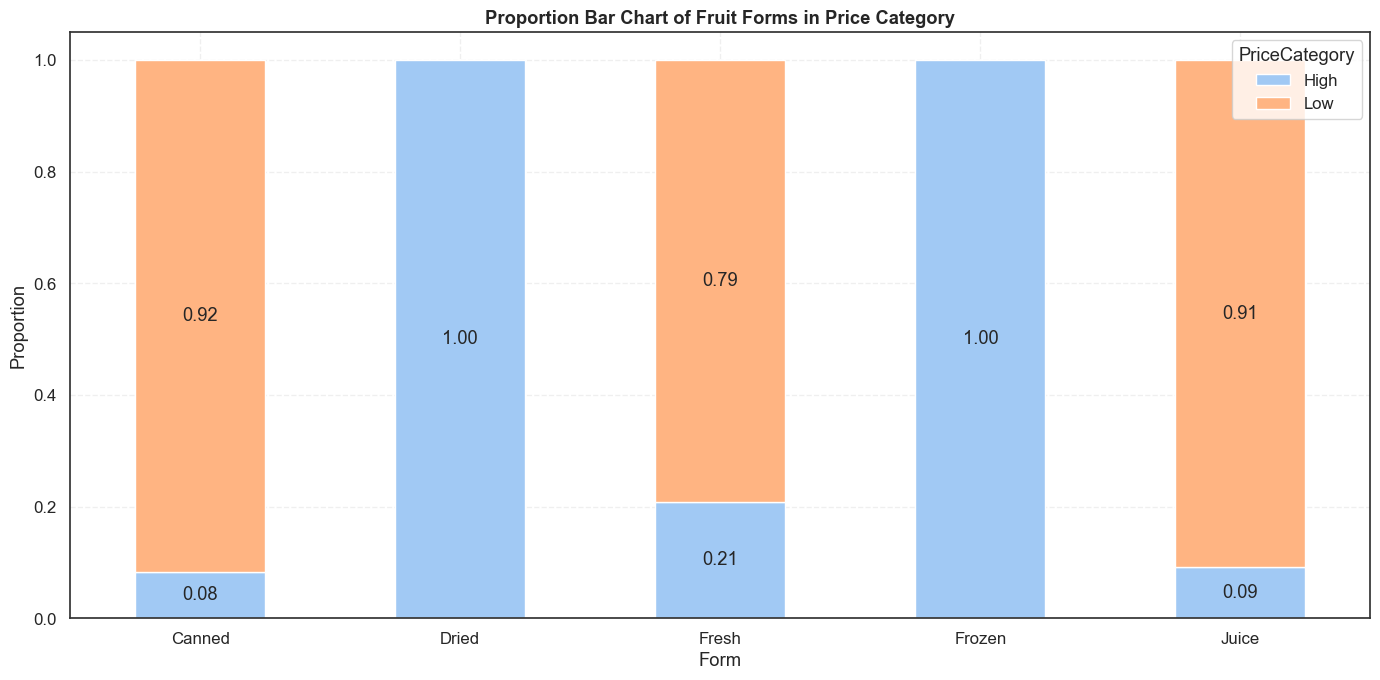

In [102]:
# Plot proportion plot
fig, ax = plt.subplots(figsize=(14, 7))
form_proportions.plot(kind='bar', stacked=True, ax=ax, rot=0)
ax.set_title('Proportion Bar Chart of Fruit Forms in Price Category')
ax.set_ylabel('Proportion')

# Iterate through each form percentage within a bar
for bar in ax.patches:
  height = bar.get_height()
  if height > 0:
    x_pos = bar.get_x()+bar.get_width()/2
    y_pos = bar.get_y() + height/2
    ax.text(
        x_pos, y_pos,
        s=f'{height:.2f}', ha='center', va='center'
    )

plt.tight_layout()
plt.show()

### 🔍 Interpretation:
This visualization shows that the `Form` of fruit is crucial to determine its price tendency. The overall high price cluster in the dataset falls into `Dried` and `Frozen` forms, while the low-price majority is dominated by `Canned`, `Fresh`, and `Juice` products. the Chi-Square test provides the statistical evidence that a relationship exists between `Form` and `PriceCategory`.

## 📊 Visualization Idea 6: Retail Price vs Cup Equivalent Price
In this section, we explore the relationship between `RetailPrice` and `CupEquivalentPrice` to determine whether fruits that cost more in `RetailPrice` also tend to cost more per edible cup. Using Pearson’s correlation, we quantify the strength and direction of the linear association between the two price measures and compute a 95% confidence interval to assess the precision of the estimate.

In [8]:
from scipy.stats import pearsonr

retail_price = df['RetailPrice']
cup_price = df['CupEquivalentPrice']
res = pearsonr(retail_price, cup_price)
ci = res.confidence_interval(0.95)
print(f'Pearsons correlation: {res[0]:.2f}')
print(f'P-value: {res[1]:.2f}')
print(f"95% CI: ({ci.low:.4f}, {ci.high:.4f})")

Pearsons correlation: 0.58
P-value: 0.00
95% CI: (0.3840, 0.7235)


Since the **p-value** is less than 0.05, there is a statistically significant association between `RetailPrice` and `CupEquivalentPrice`.  
**Pearsons correlation (0.58)** indicates moderate positive relationship.  
**95% CI (0.3840, 0.7235)** suggests that the true correlation is likely moderate positive. Because the entire interval is above zero, the relationship is reliably postitive, and unliky due to random chance.

Now we’ll use Plotly to create a scatter plot so we can see the trend and take advantage of its interactive hover features to determine which fruits bring the most value.

In [ ]:
# Plot scatter plot
fig = px.scatter(
    df,
    x="RetailPrice",
    y="CupEquivalentPrice",
    trendline="ols",
    hover_data='Fruit',
    opacity=0.5,
    title="Scatter Plot of Retail Price vs Cup Equivalent Price"
)

fig.show()

Scatter plots help identify correlations between retail price and the actual edible value (`CupEquivalentPrice`).  
Labeling by its name allows comparison of different kinds of fruits.


### 🔍 Interpretation:
This visualization shows a clear upward trend between `RetailPrice` and `CupEquivalentPrice`. It means the products with higher `RetailPrice` tend to have higher `CupEquivalentPrice`. Most points follow a fairly straight pattern, the spread gets a bit wider for higher price fruits, which means there are some fruits (Mangoes, Papaya, Apricots, etc) with the high `RetailPrice` but more reasonable `CupEquivalentPrice` comparing to the trend line because they contains lots of edible flesh.

The conclusion matches with the statiscal calculation, showing there is a reliably moderate positive correlation between `RetailPrice` and `CupEquivalentPrice`



## 📊 Visualization Idea 7: Distribution of Fruit Forms


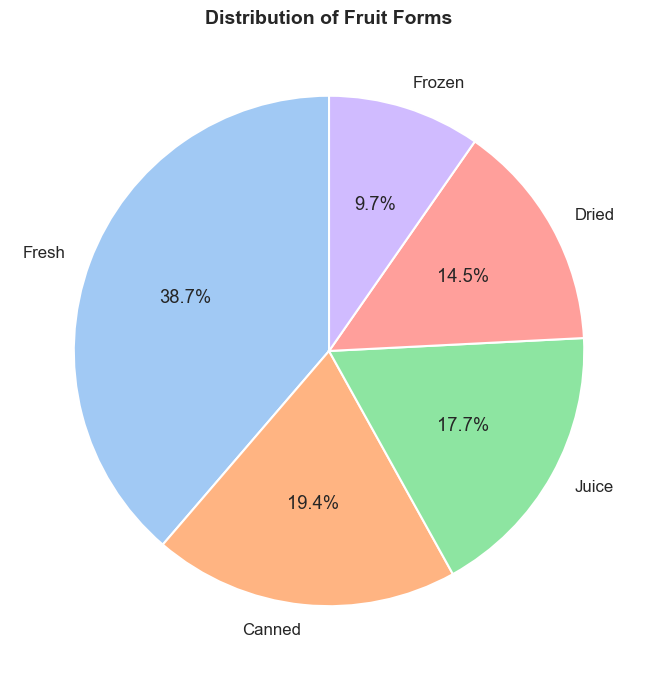

In [121]:
form_count = df['Form'].value_counts()
form_order = df['Form'].unique().tolist()

fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(form_count, labels=form_order, autopct='%1.1f%%', startangle=90,
       wedgeprops={'edgecolor': 'white',
                   'linewidth': 1.5})
ax.set_title('Distribution of Fruit Forms', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

A pie chart helps visualize which forms of fruit products dominate the dataset.  
This is useful for understanding market availability and consumer access.


## 6. Appendix: Resources and References

- **Dataset:** USDA Economic Research Service – Fruit and Vegetable Prices  
  [Link](https://www.ers.usda.gov/data-products/fruit-and-vegetable-prices/)
- **License:** CC0  
  [Link](http://www.opendefinition.org/licenses/cc-zero)
- **Libraries Used:** pandas, matplotlib, seaborn, plotly, SciPy, pathlib

### Statistical References

The following resources were referenced for statistical testing, effect size calculations, and Python implementations. They provide guidance on both theory and practical application:

- **Independent Sample t-Test: Theory, Application, and Interpretation**  
  [https://www.statisticalaid.com/independent-sample-t-test/](https://www.statisticalaid.com/independent-sample-t-test/)  

- **T-test Assumption Check in Python**  
  [https://www.pythonfordatascience.org/independent-samples-t-test-python/#assumption_check](https://www.pythonfordatascience.org/independent-samples-t-test-python/#assumption_check)  

- **Non-Parametric Tests Overview**  
  [https://www.geeksforgeeks.org/artificial-intelligence/non-parametric-tests/](https://www.geeksforgeeks.org/artificial-intelligence/non-parametric-tests/)  

- **Cohen's D Effect Size Calculation**  
  [https://www.askpython.com/python/examples/cohens-d-python](https://www.askpython.com/python/examples/cohens-d-python)  

- **SciPy Chi-Square Function Reference**  
  [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html)  

- **Chi-Square Test of Independence in Python Tutorial**  
  [https://datagy.io/chi-square-test-of-independence-in-python/](https://datagy.io/chi-square-test-of-independence-in-python/)
